In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import h5py
import seaborn as sns
from scipy.special import logit
from scipy.special import expit
from scipy.interpolate import RegularGridInterpolator
from pylab import rcParams
import sys
import torch
import scipy

import sys
sys.path.append('../')
from populations.bbh_models import read_hdf5
from populations.bbh_models import get_models
from populations.Flowsclass_dev import FlowModel
from populations.utils.bounded_Nd_kde import Bounded_Nd_kde

In [60]:
#flags/inputs:
param = ['mchirp','q', 'chieff', 'z']
no_params = len(param)
channel_label = 'GC'

channel_ids = {'CE':0, 'CHE':1,'GC':2,'NSC':3, 'SMT':4}
channel_id = channel_ids[channel_label] #will be 0, 1, 2, 3, or 4
chi_b = [0.0,0.1,0.2,0.5]
alpha_CE = [0.2,0.5,1.0,2.,5.]
channel_samples = [4e6,864124,896611,582961, 4e6]
no_binaries = int(channel_samples[channel_id])
batch_size = 10000
total_hps=4

models_path ='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
popsynth_outputs = read_hdf5(models_path, channel_label) # read all data from hdf5 file

models_dict = dict.fromkeys(popsynth_outputs.keys())
weights_dict = dict.fromkeys(popsynth_outputs.keys())


for key in popsynth_outputs.keys():
    models_dict[key] = popsynth_outputs[key][param]
    weights_dict[key]= popsynth_outputs[key]['weight']


In [81]:
#check that these distributions are the same between the whole (transformed distribution), batch, and the same for validation data
#no_trans, no_neurons, training_inputs, cond_inputs,no_binaries, batch_size, total_hps, RNVP=True, num_bins=4, device="cpu"):
flow = FlowModel(channel_label, popsynth_outputs, param)
weighted_flow = FlowModel(channel_label, popsynth_outputs, param)
model_names, KDE_models = get_models(models_path, [channel_label], param, use_flows=False, spin_distr=None, sensitivity='midhighlatelow_network', normalize=False, detectable=False)
_, KDE_models_detectable = get_models(models_path, [channel_label], param, use_flows=False, spin_distr=None, sensitivity='midhighlatelow_network', normalize=False, detectable=True)


100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


In [62]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [82]:
model_names, KDE_models_mchirp = get_models(models_path, [channel_label], ['mchirp'], use_flows=False, spin_distr=None, sensitivity='midhighlatelow_network', normalize=False, detectable=False)

100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


## Check the integration of p(theta|chi,alpha) over dtheta

In [83]:
super(Bounded_Nd_kde,KDE_models[channel_label]['chi00'].kde).integrate_box([-1000.,-50.,-100.,-50.],[10000.,10.,10.,100.])

1.0000000000000275

In [84]:
super(Bounded_Nd_kde,KDE_models[channel_label]['chi00'].kde).integrate_box([0.,0.,-1.,0.],[100.,1.,1.,10.])

/Users/stormcolloms/opt/anaconda3/envs/amaze/lib/python3.9/site-packages/scipy/stats/_kde.py:376: UserWarning: An integral in _mvn.mvnun requires more points than 4000
  warnings.warn(msg)


0.03999930583483015

In [85]:
super(Bounded_Nd_kde,KDE_models_mchirp[channel_label]['chi00'].kde).integrate_box([-1000.],[10000.])

0.9999999999999861

In [86]:
super(Bounded_Nd_kde,KDE_models_mchirp[channel_label]['chi00'].kde).integrate_box([0.],[100.])

0.33333333333332904

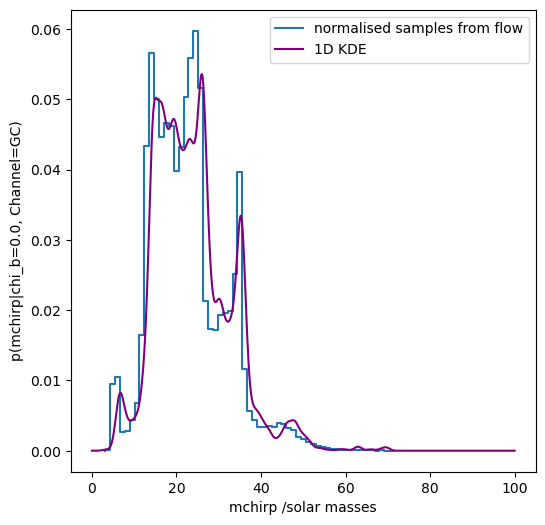

In [80]:
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 10})
flow_samples_stack = weighted_flow.flow.sample(no_samples, np.array([0.]))
flow_mchirp = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
flow_distr, bin_edges = np.histogram(flow_mchirp, bins=no_bins, density=True)
plt.step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='normalised samples from flow')
plt.plot(np.linspace(0.,100.,1000), KDE_models_mchirp['GC']['chi00'].pdf(np.linspace(0.,100.,1000)), label='1D KDE', color='purple')
plt.xlabel('mchirp /solar masses')
plt.ylabel('p(mchirp|chi_b=0.0, Channel=GC)')
plt.legend()

In [41]:
mchirps = np.linspace(0.1,99.9,50)
qs = np.linspace(0.01,0.99,50)
chieffs = np.linspace(-0.99,0.99,50)
zs = np.linspace(0.1,9.9, 50)
param_grid = np.array(np.meshgrid(mchirps,qs,chieffs,zs)).T.reshape(1,-1,4)

mapped_sample = weighted_flow.map_obs(param_grid)

test_conditional=np.reshape((np.tile([0,0.5],np.shape(param_grid)[1])),(1,-1,2))
ptheta_achi_flow_persamp=weighted_flow.flow.get_logprob(param_grid, mapped_sample, weighted_flow.mappings, test_conditional)

(1, 6250000, 2)


In [43]:
ptheta_achi_flow_persamp

array([[-1200.067  , -1186.9038 , -1179.4044 , ...,  -513.14935,
         -512.3865 ,  -508.45038]], dtype=float32)

In [42]:
#this isn't going to be right cus its just doing 1d integration, can;t know what x and dx are in 1D
np.trapz(ptheta_achi_flow_persamp)

array([-9.3172026e+08], dtype=float32)

In [71]:
flow.load_model('./', channel_label)
weighted_flow.load_model('./cosmo_weights/newmappings_2/', channel_label)

## Unweighted flow distributions - nonCE

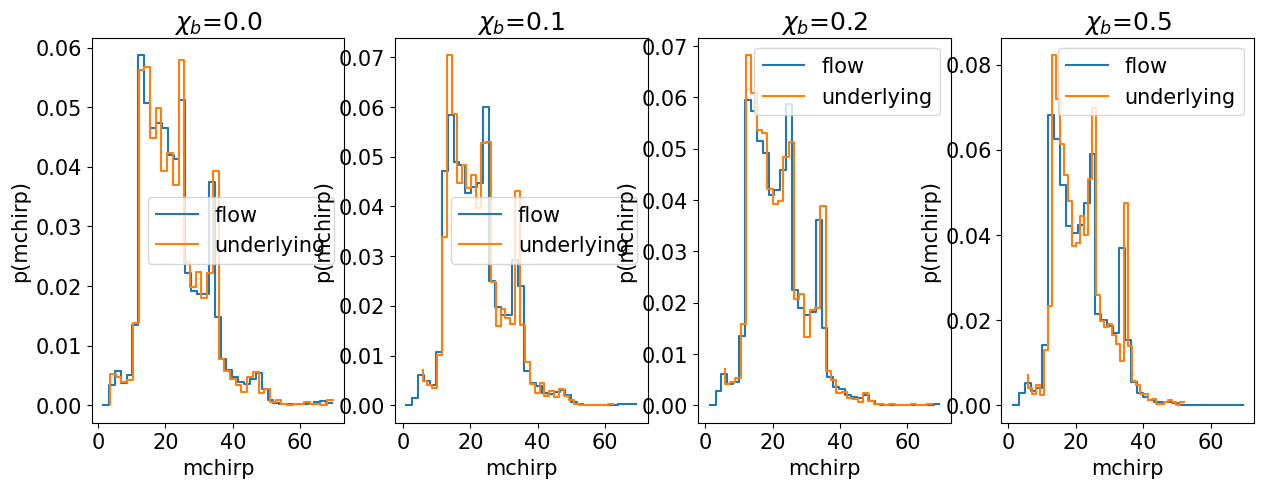

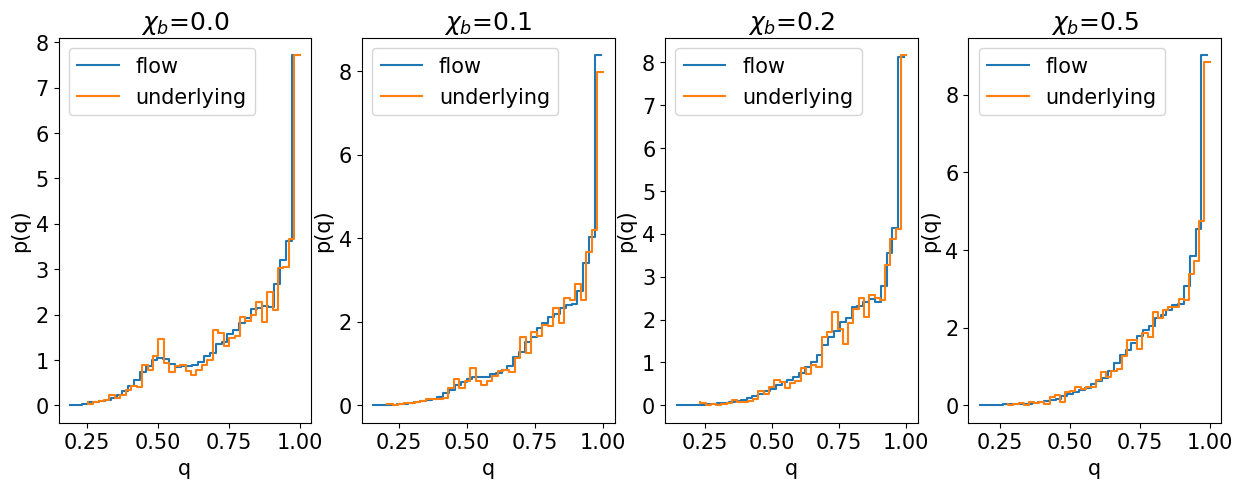

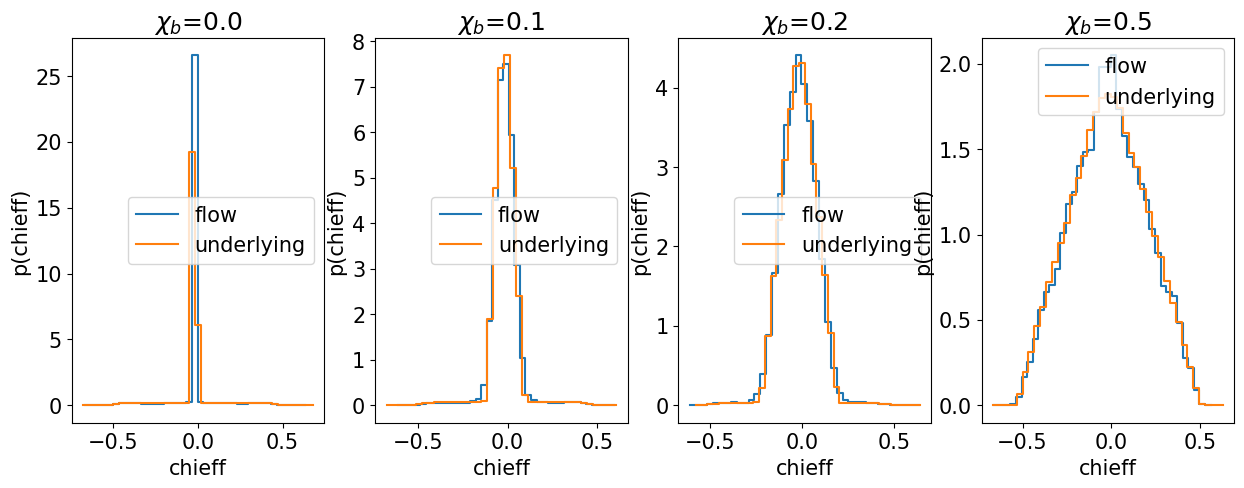

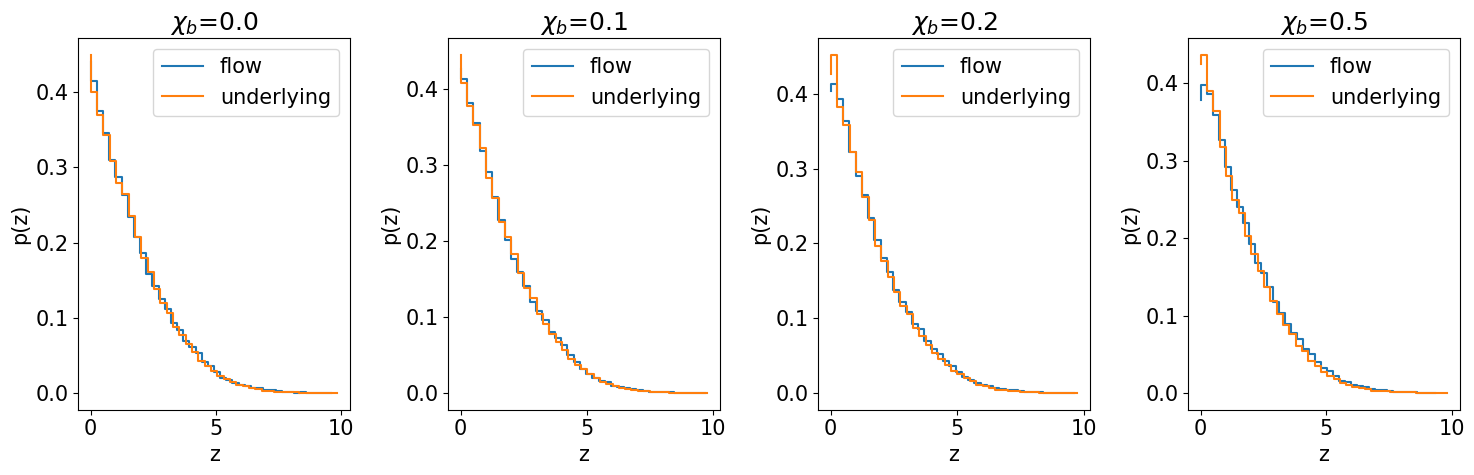

In [16]:
plt.rcParams["figure.figsize"] = (15,5)
no_samples = 100000
no_bins = 40

fig_mchirp, ax_m = plt.subplots(1,4)
fig_q, ax_q = plt.subplots(1,4)
fig_c, ax_c = plt.subplots(1,4)
fig_z, ax_z = plt.subplots(1,4)

for chi_b_id, xb in enumerate(chi_b):
    flow_samples_stack = flow.flow.sample(no_samples, np.array([xb]))
    flow_mchirp = flow.expistic(flow_samples_stack[:,0], flow.mappings[0], flow.mappings[1])
    flow_q = flow.expistic(flow_samples_stack[:,1], flow.mappings[2])
    flow_chieff = np.tanh(flow_samples_stack[:,2])
    flow_z = flow.expistic(flow_samples_stack[:,3], flow.mappings[4], flow.mappings[5])

    mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

    for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
        flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
        known_distr, bin_edges_known =np.histogram(models_dict[chi_b_id][:][param[i]], bins=no_bins, density=True)
        ax[chi_b_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
        ax[chi_b_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
        ax[chi_b_id].set_title(fr'$\chi_b$={xb}')
        ax[chi_b_id].set_xlabel(f'{param[i]}')
        ax[chi_b_id].set_ylabel(f'p({param[i]})')
        ax[chi_b_id].legend()
        plt.tight_layout()

## Weighted Flow distributions - nonCE

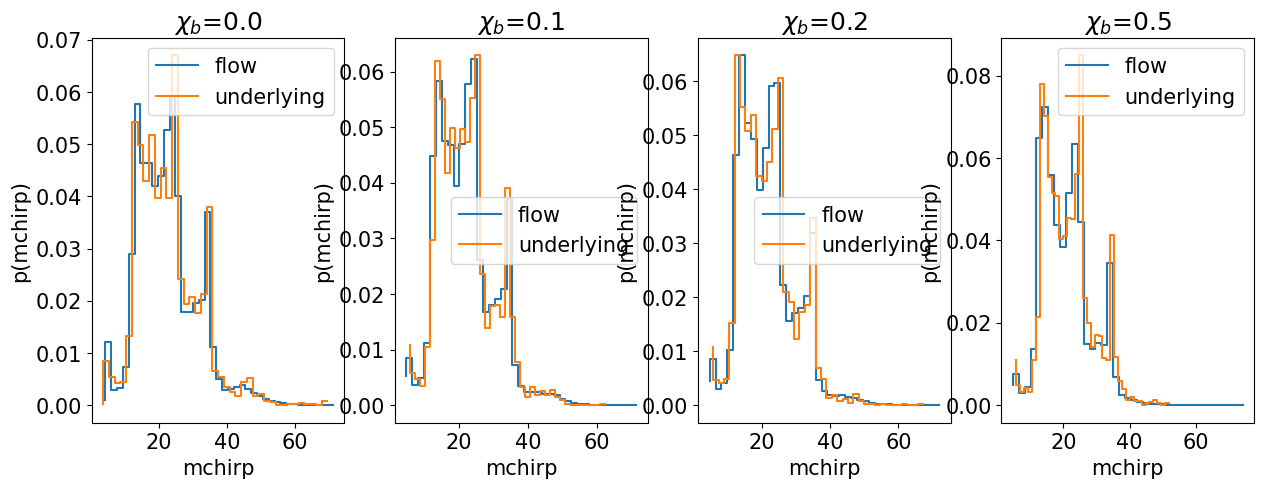

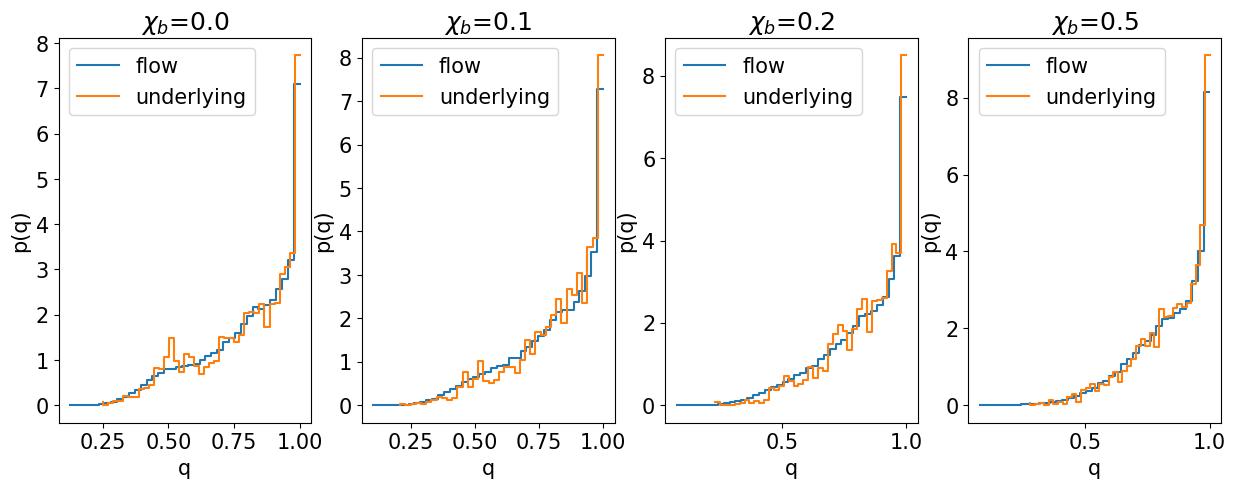

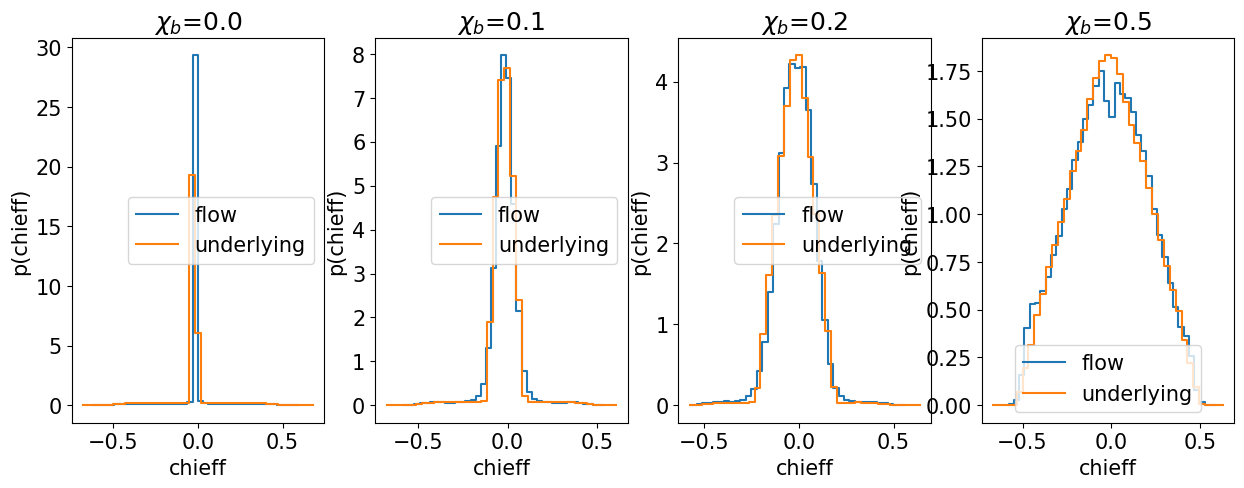

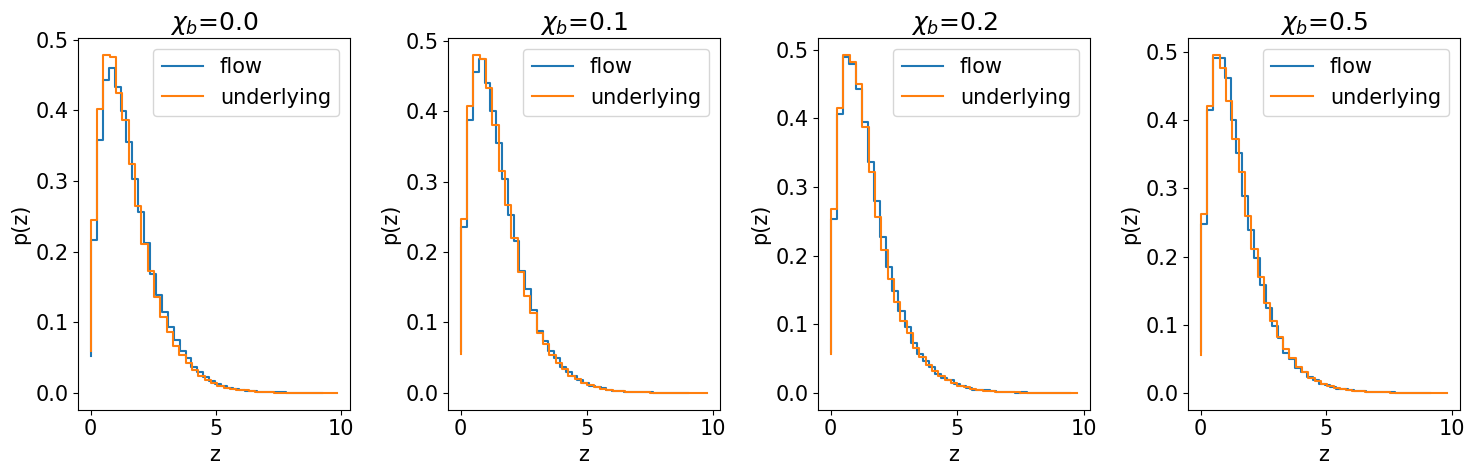

In [17]:
plt.rcParams["figure.figsize"] = (15,5)
no_samples = 100000
no_bins = 40

fig_mchirp, ax_m = plt.subplots(1,4)
fig_q, ax_q = plt.subplots(1,4)
fig_c, ax_c = plt.subplots(1,4)
fig_z, ax_z = plt.subplots(1,4)

for chi_b_id, xb in enumerate(chi_b):
    flow_samples_stack = weighted_flow.flow.sample(no_samples, np.array([xb]))
    flow_mchirp = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
    flow_q = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
    flow_chieff = np.tanh(flow_samples_stack[:,2])
    flow_z = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

    mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

    for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
        flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
        known_distr, bin_edges_known =np.histogram(models_dict[chi_b_id][:][param[i]], bins=no_bins, density=True, weights=weights_dict[chi_b_id])
        ax[chi_b_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
        ax[chi_b_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
        ax[chi_b_id].set_title(fr'$\chi_b$={xb}')
        ax[chi_b_id].set_xlabel(f'{param[i]}')
        ax[chi_b_id].set_ylabel(f'p({param[i]})')
        ax[chi_b_id].legend()
        plt.tight_layout()

## Unweighted distributions - CE

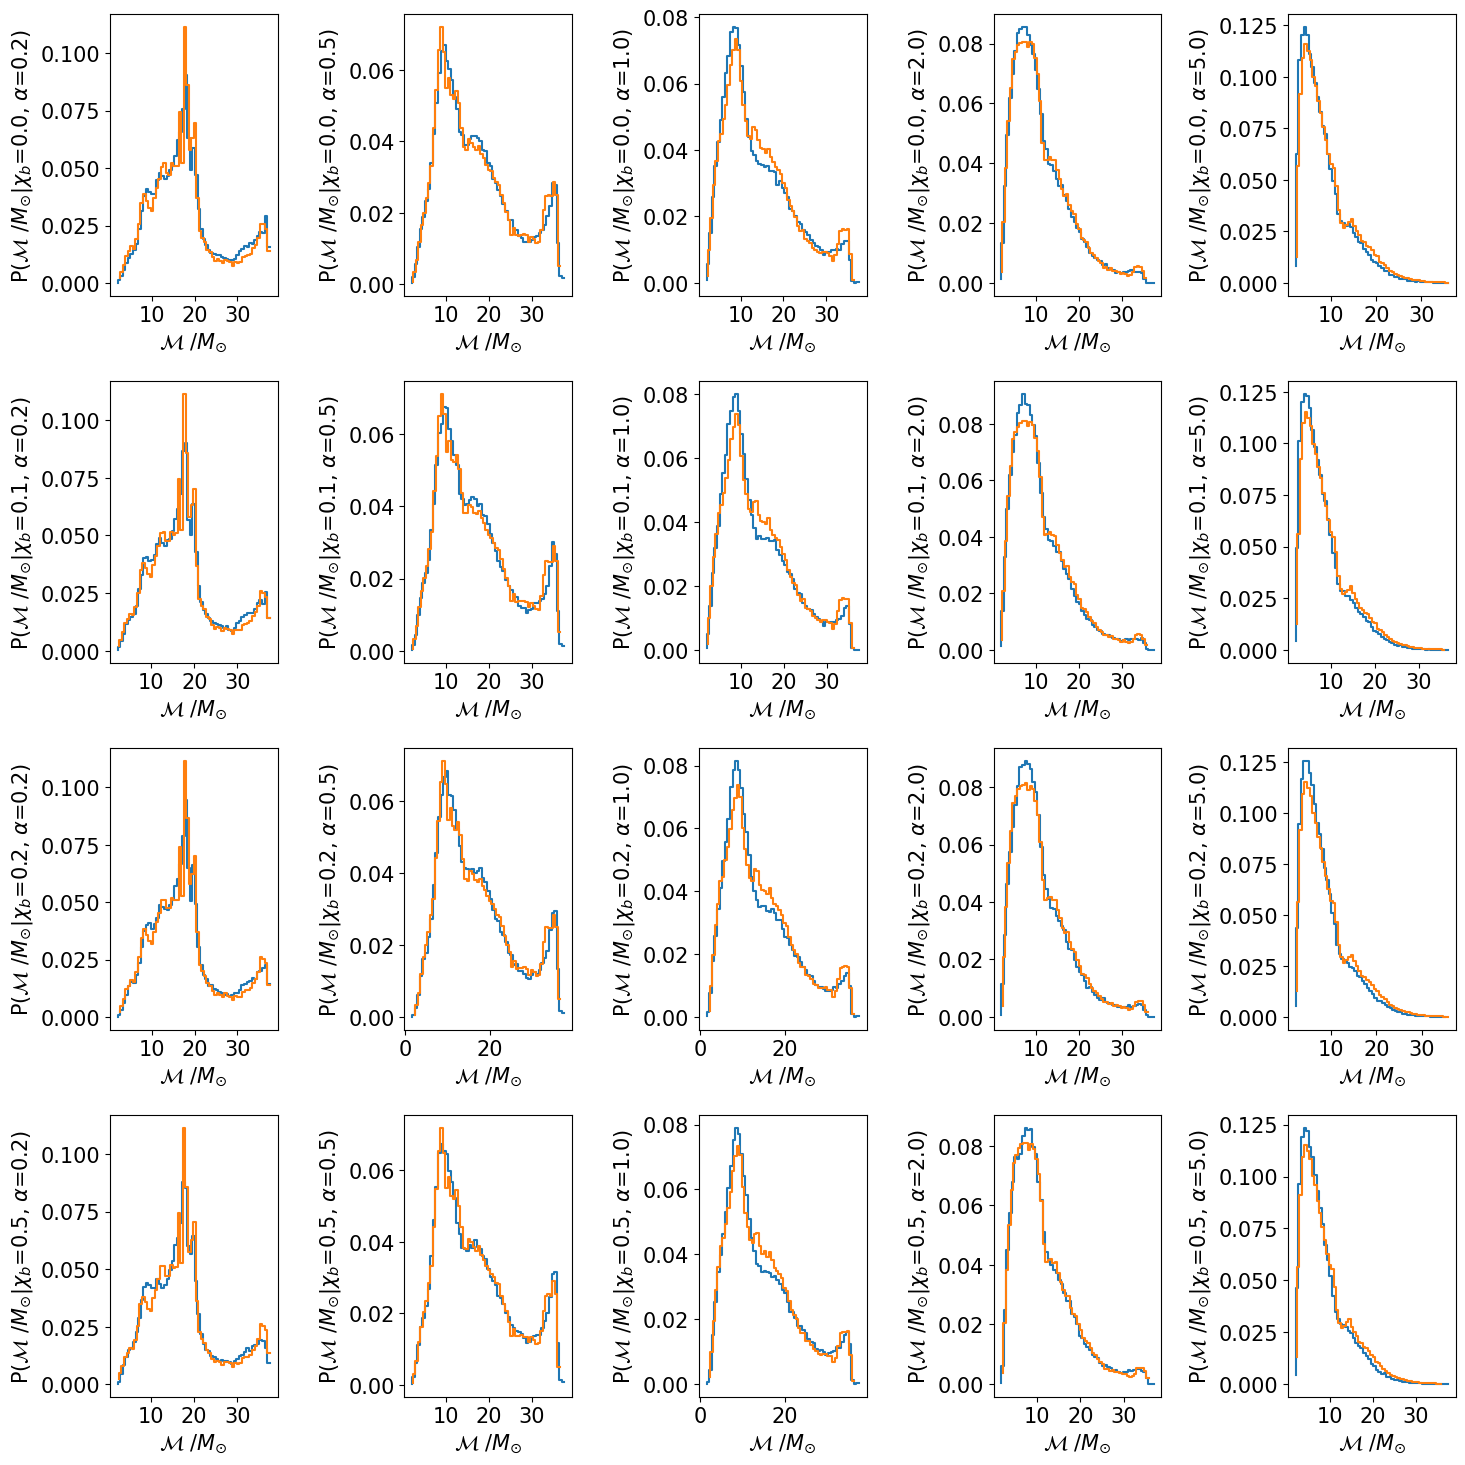

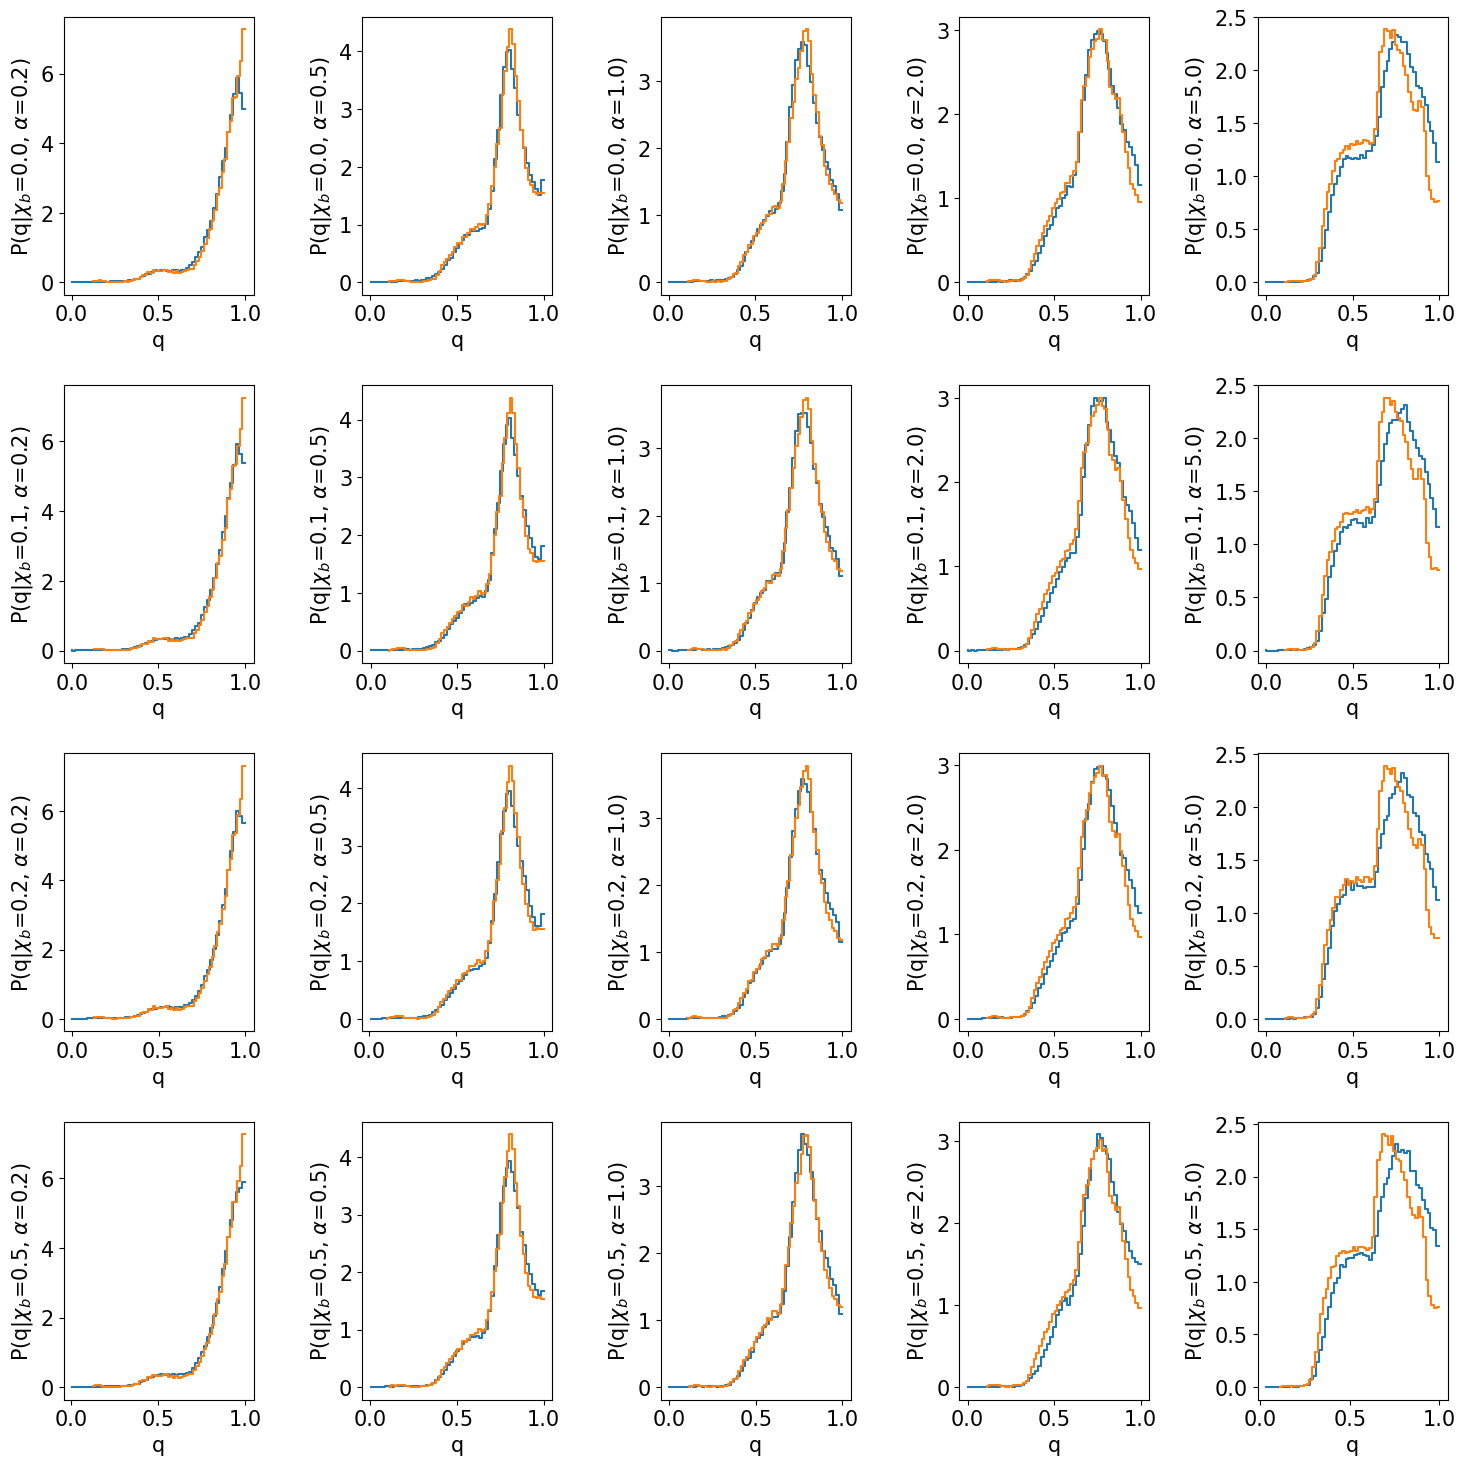

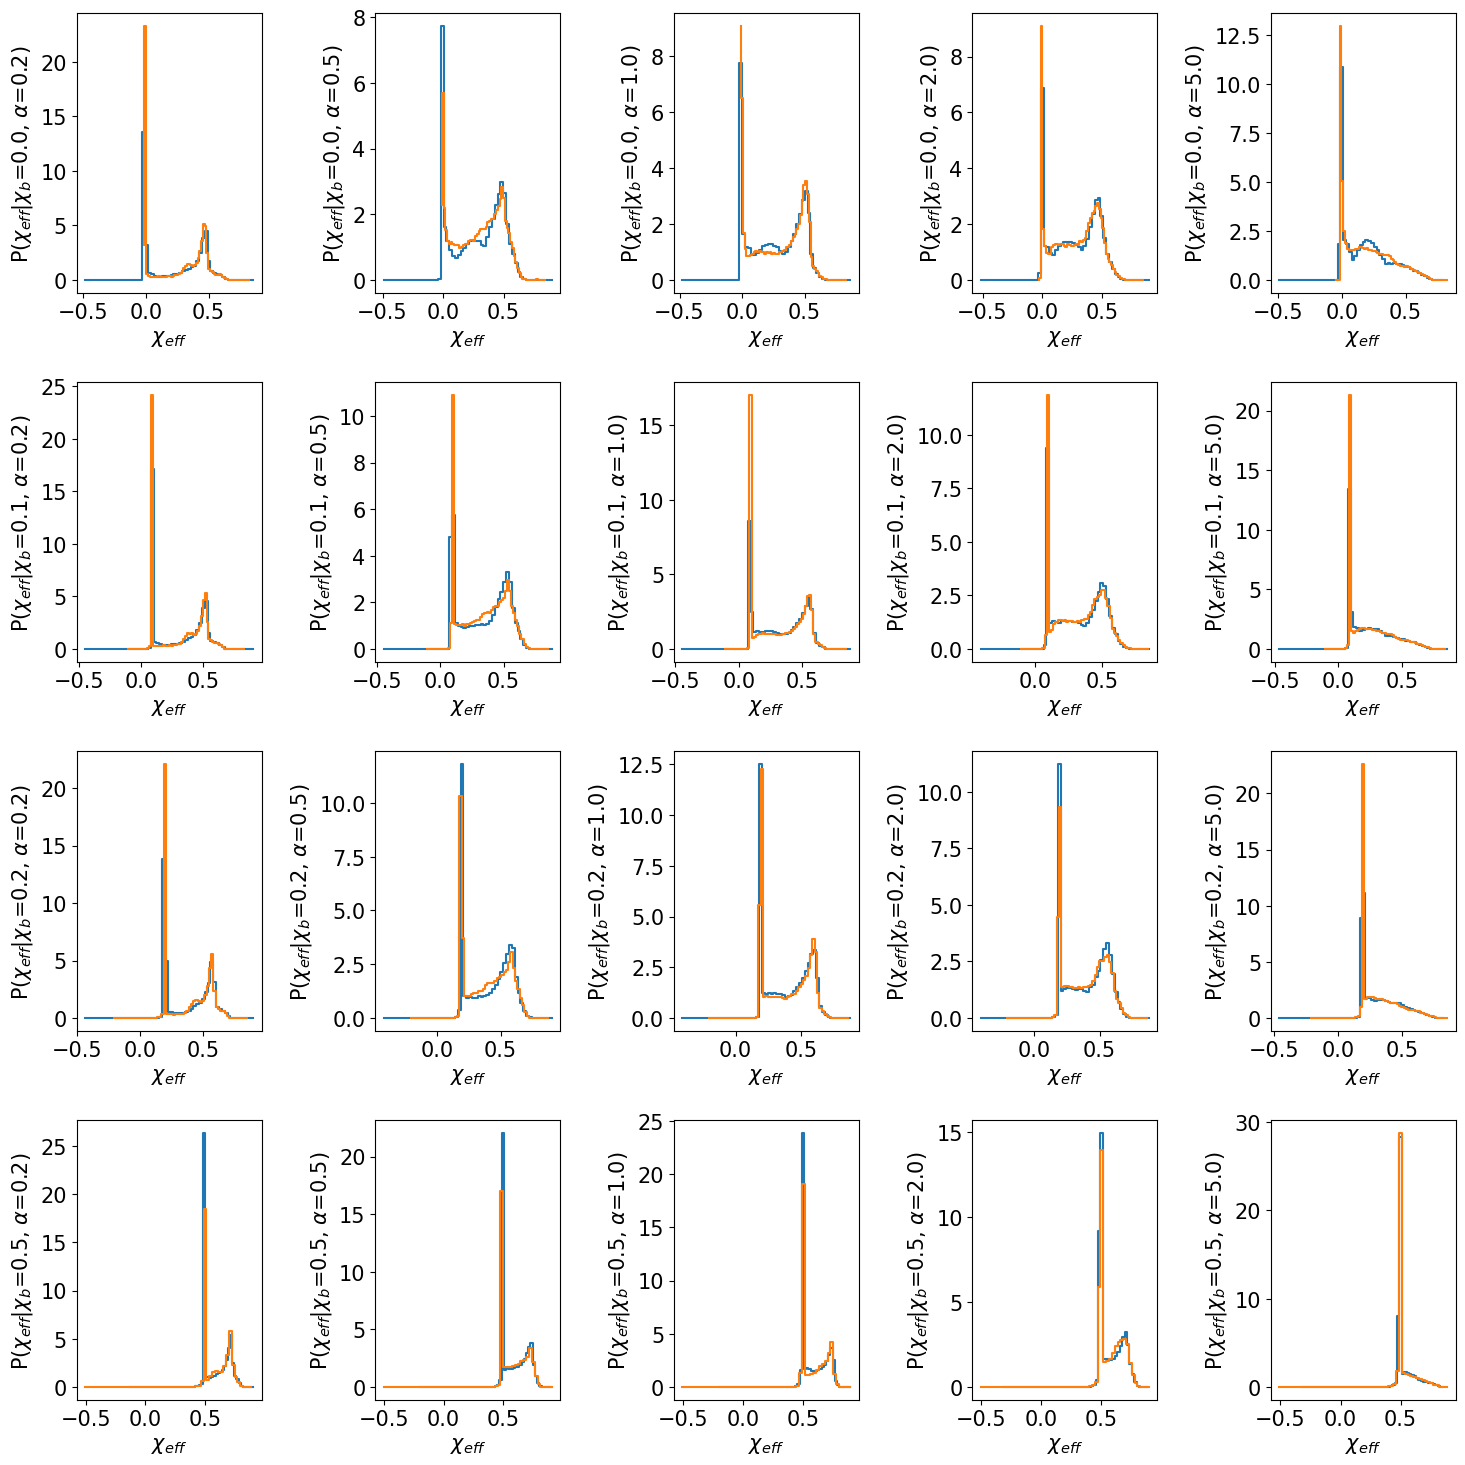

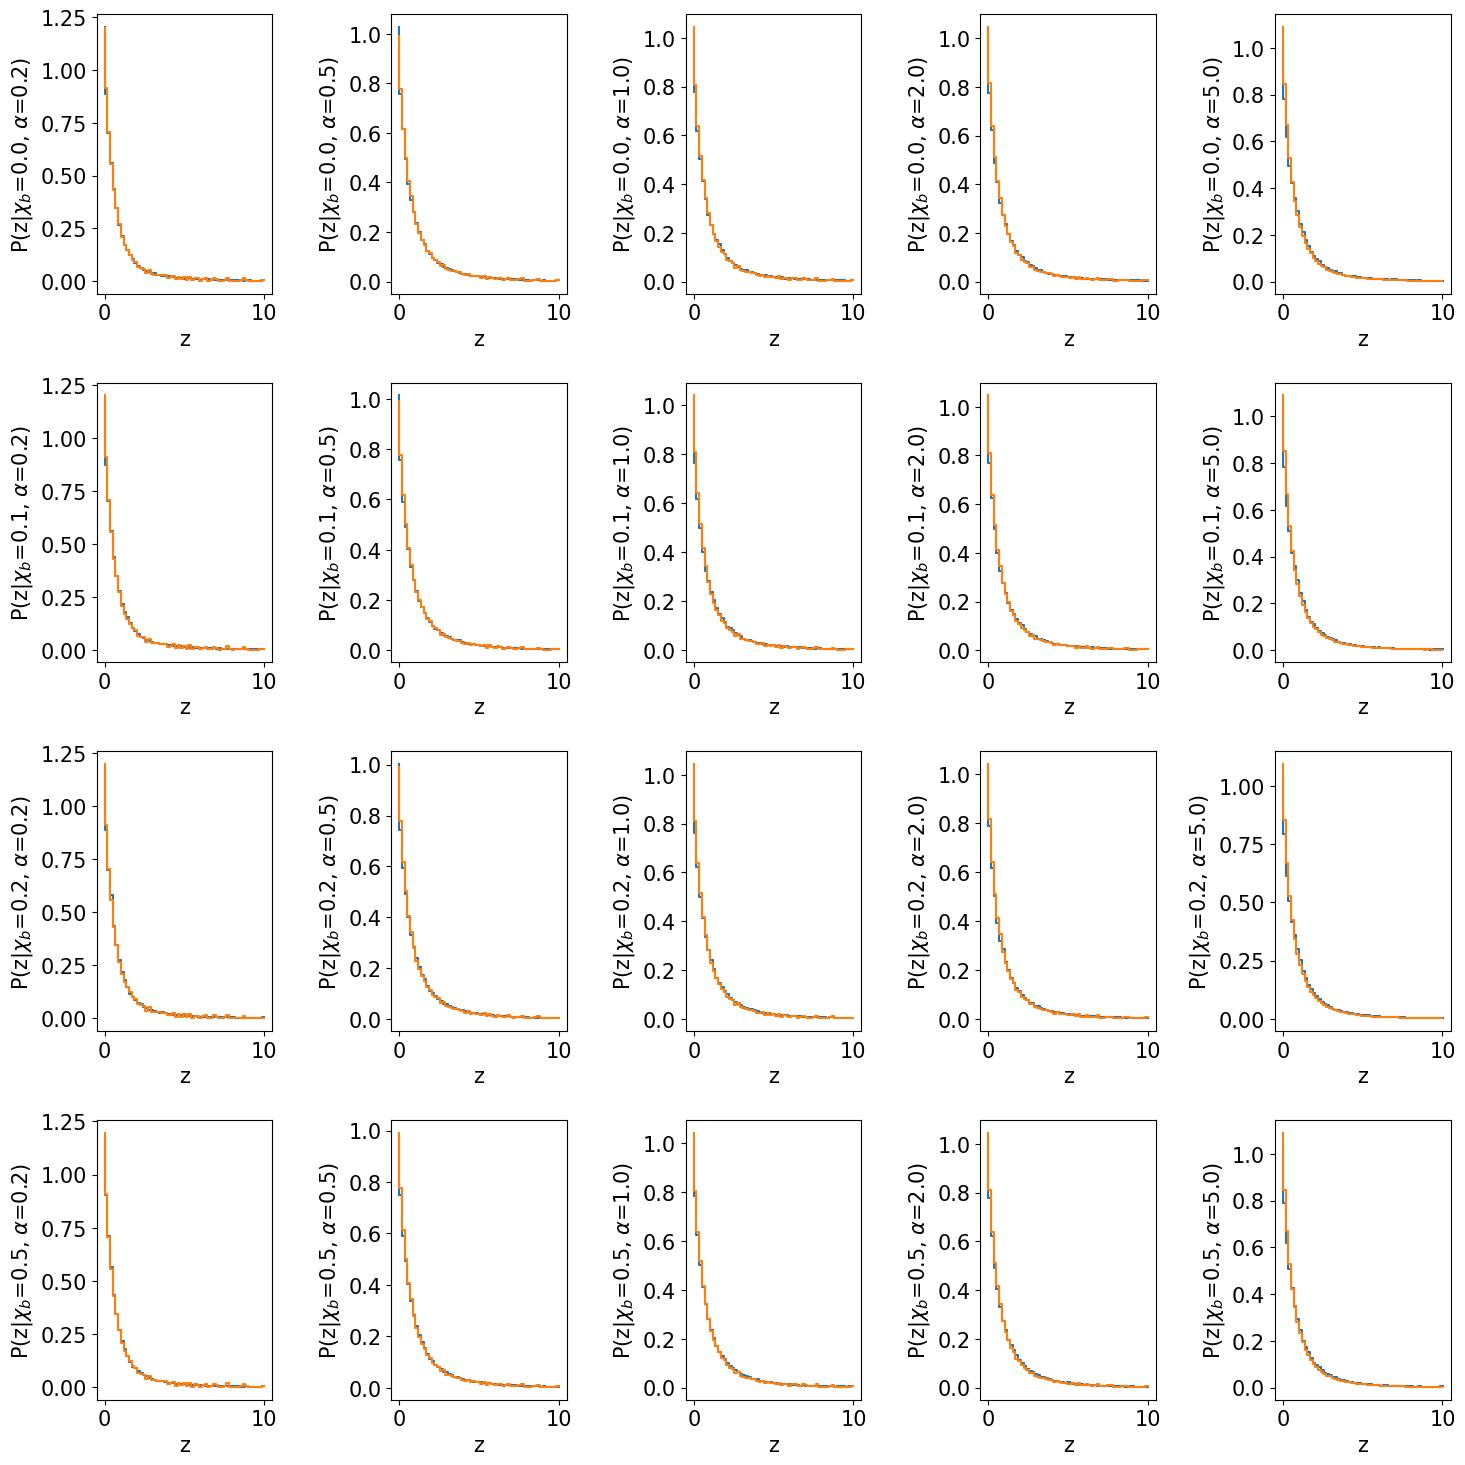

In [6]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
no_samples = 100000
no_bins = 60

fig_mchirp, ax_m = plt.subplots(4,5)
fig_q, ax_q = plt.subplots(4,5)
fig_c, ax_c = plt.subplots(4,5)
fig_z, ax_z = plt.subplots(4,5)

param_label = ['$\mathcal{M}$ /$M_{\odot}$','q', '$\chi_{eff}$', 'z']

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        flow_samples_stack = flow.flow.sample(no_samples, np.array([xb,a]))
        flow_mchirp = flow.expistic(flow_samples_stack[:,0], flow.mappings[0], flow.mappings[1])
        flow_q = flow.expistic(flow_samples_stack[:,1], flow.mappings[2])
        flow_chieff = np.tanh(flow_samples_stack[:,2])
        flow_z = flow.expistic(flow_samples_stack[:,3], flow.mappings[4], flow.mappings[5])

        mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

        for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
            flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
            known_distr, bin_edges_known =np.histogram(models_dict[(chi_b_id,alpha_id)][:][param[i]], bins=no_bins, density=True)
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
            #ax[chi_b_id,alpha_id].set_title(fr'$\chi_b$={xb} and $\alpha$={a}')
            ax[chi_b_id,alpha_id].set_xlabel(fr'{param_label[i]}')
            ax[chi_b_id,alpha_id].set_ylabel(fr'P({param_label[i]}|$\chi_b$={xb}, $\alpha$={a})')
            #ax[chi_b_id,alpha_id].legend()
            fig_mchirp.tight_layout(pad=1.3)
            fig_c.tight_layout(pad=1.3)
            fig_q.tight_layout(pad=1.3)
            fig_z.tight_layout(pad=1.3)

## Cosmo weighted Distributions - CE

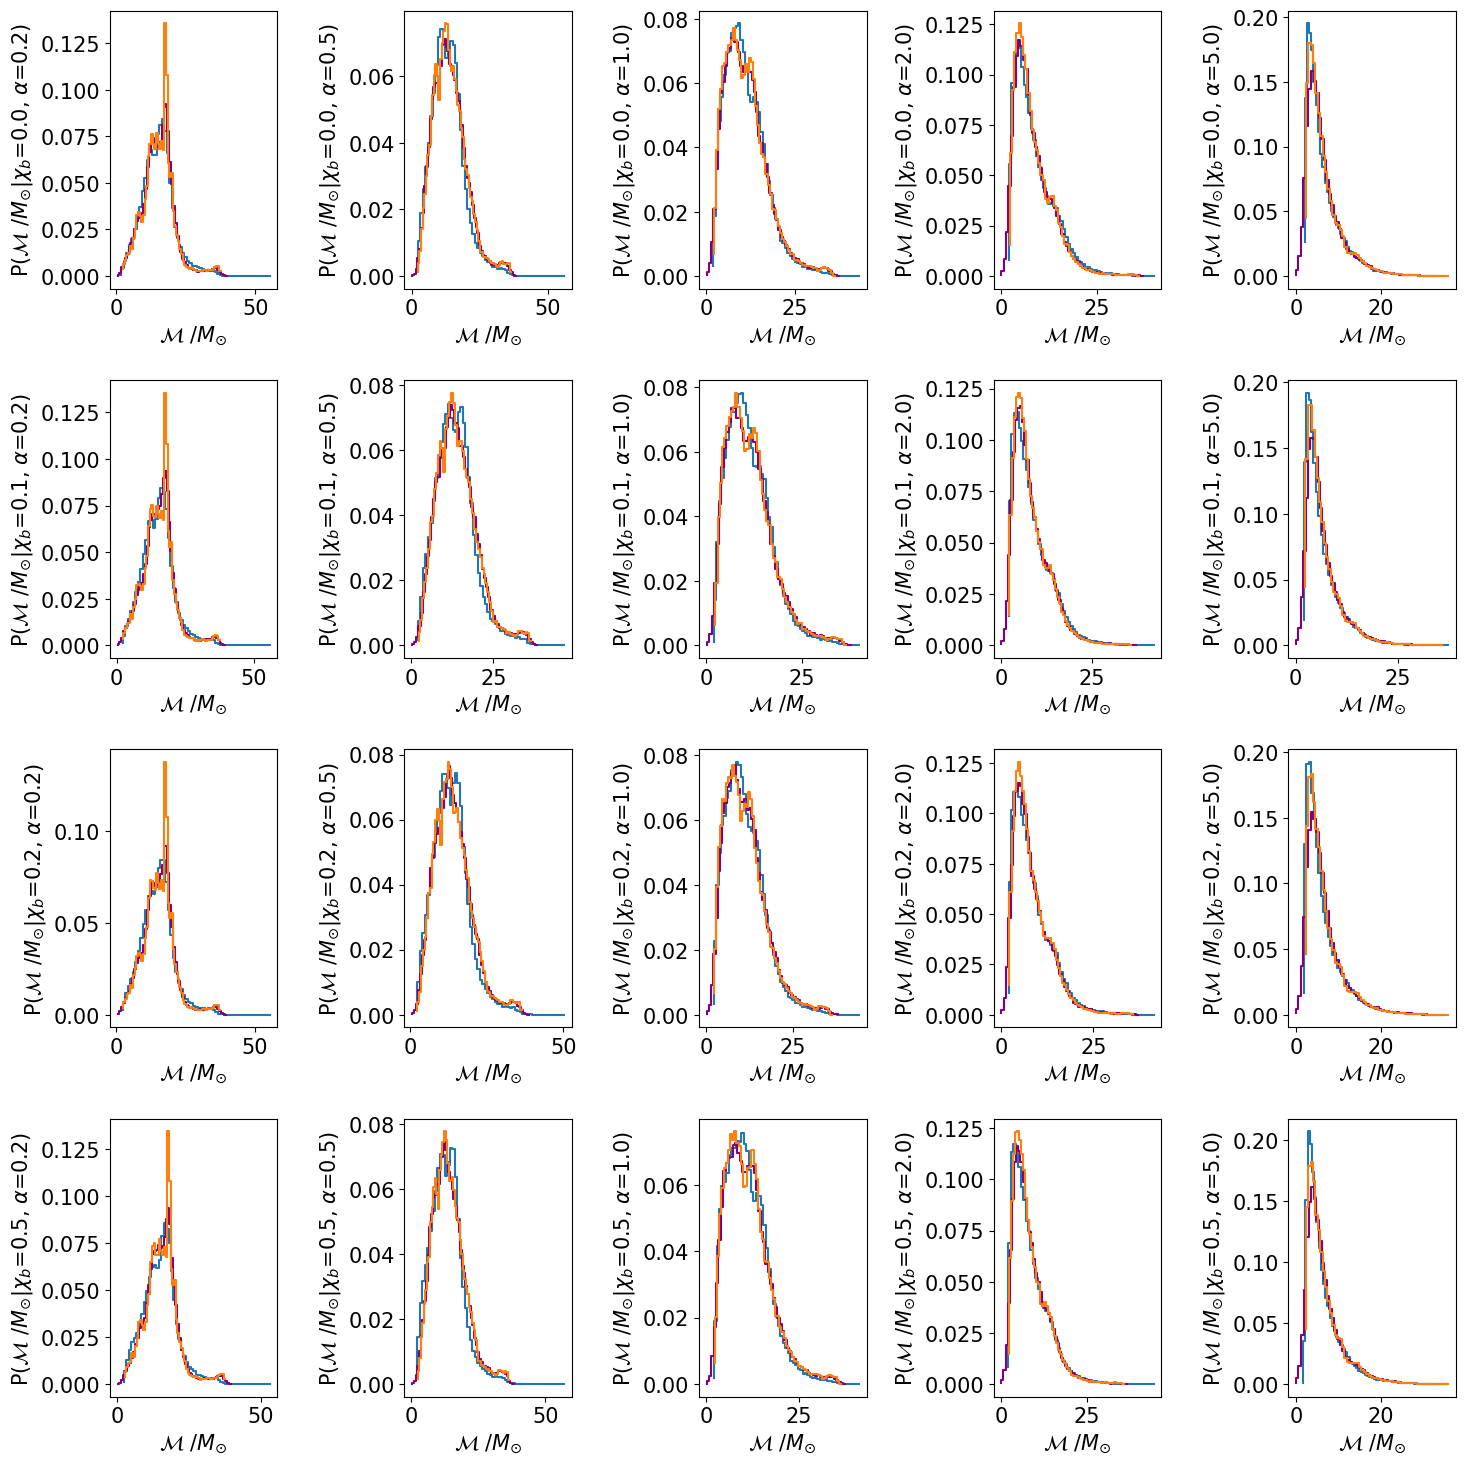

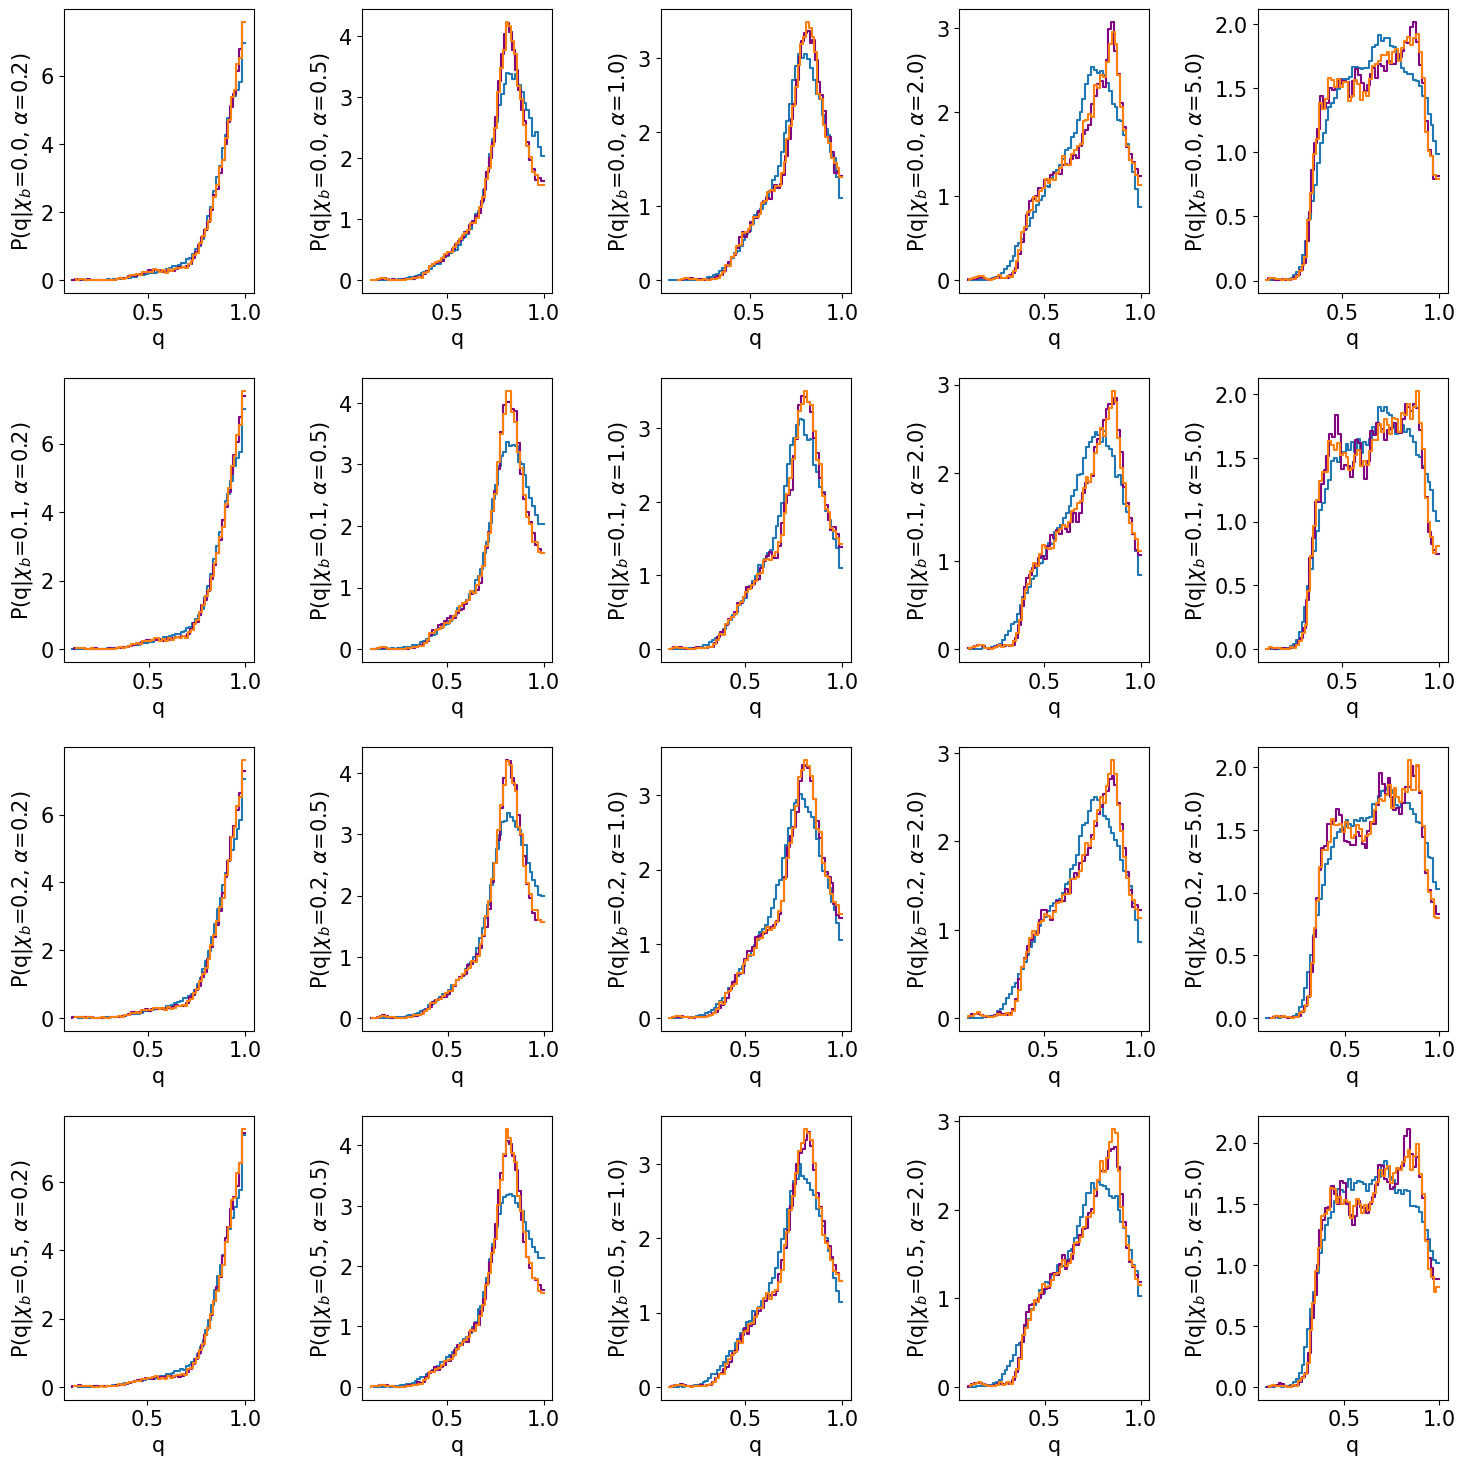

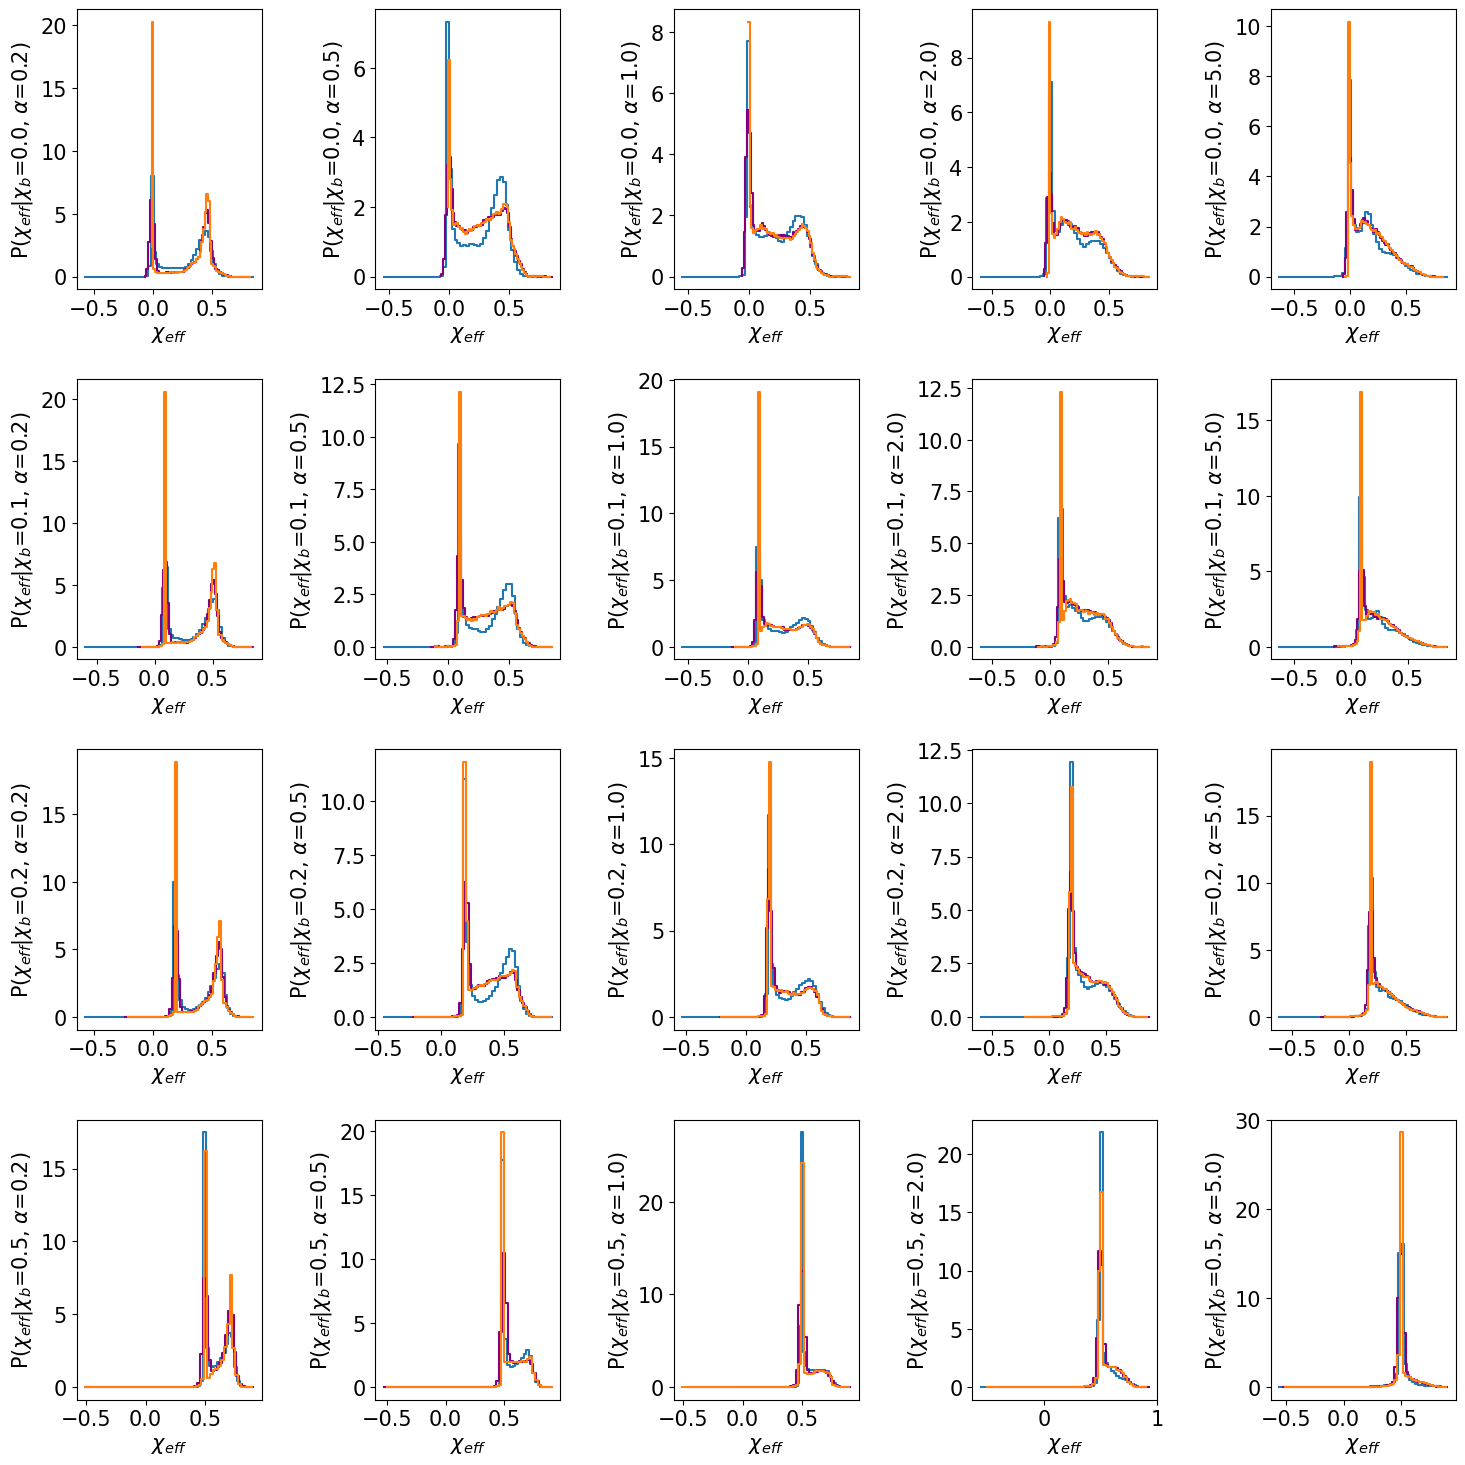

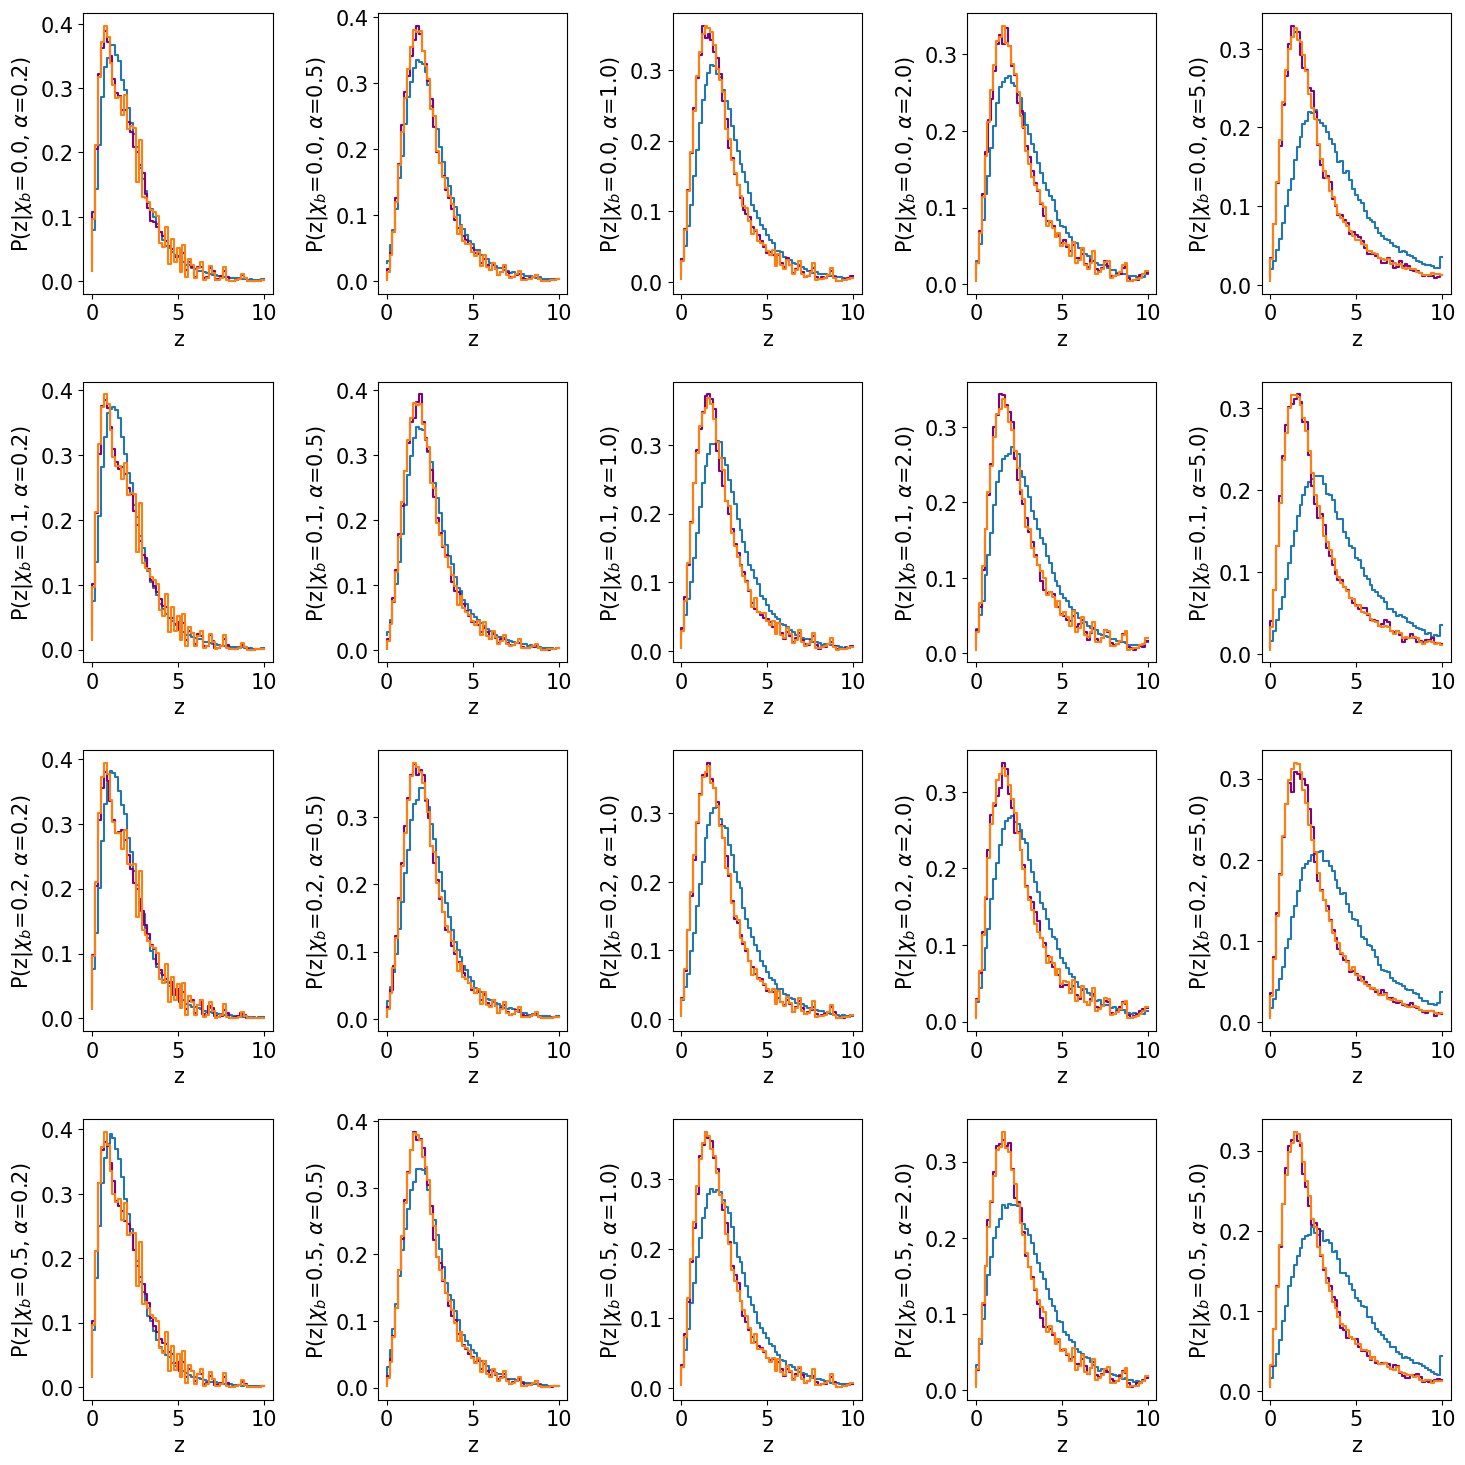

In [59]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
no_samples = 100000
no_bins = 60

fig_mchirp, ax_m = plt.subplots(4,5)
fig_q, ax_q = plt.subplots(4,5)
fig_c, ax_c = plt.subplots(4,5)
fig_z, ax_z = plt.subplots(4,5)

param_label = ['$\mathcal{M}$ /$M_{\odot}$','q', '$\chi_{eff}$', 'z']

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        flow_samples_stack = weighted_flow.flow.sample(no_samples, np.array([xb,a]))
        flow_mchirp = weighted_flow.expistic(flow_samples_stack[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
        flow_q = weighted_flow.expistic(flow_samples_stack[:,1], weighted_flow.mappings[2])
        flow_chieff = np.tanh(flow_samples_stack[:,2])
        flow_z = weighted_flow.expistic(flow_samples_stack[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

        mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

        kde_samples = KDE_models['CE'][submodels_dict[0][chi_b_id]][submodels_dict[1][alpha_id]].sample(no_samples)

        for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
            flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
            kde_distr, bin_edges_KDE = np.histogram(kde_samples[:,i], bins=no_bins, density=True)
            known_distr, bin_edges_known =np.histogram(models_dict[(chi_b_id,alpha_id)][:][param[i]], bins=no_bins, density=True, weights=weights_dict[(chi_b_id,alpha_id)][:])
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_KDE[0],bin_edges_KDE[-1],no_bins),kde_distr,label='KDE', color='purple')
            ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
            #ax[chi_b_id,alpha_id].set_title(fr'$\chi_b$={xb} and $\alpha$={a}')
            ax[chi_b_id,alpha_id].set_xlabel(fr'{param_label[i]}')
            ax[chi_b_id,alpha_id].set_ylabel(fr'P({param_label[i]}|$\chi_b$={xb}, $\alpha$={a})')
            #ax[chi_b_id,alpha_id].legend()
            fig_mchirp.tight_layout(pad=1.3)
            fig_c.tight_layout(pad=1.3)
            fig_q.tight_layout(pad=1.3)
            fig_z.tight_layout(pad=1.3)